In [19]:
import json
import pandas as pd

def json_to_csv(json_file):
    
    with open(json_file) as file:
        parsed_data = json.load(file)
    
    for issue in parsed_data['issues']:
        issue['line_number'] = issue['textRange']['startLine']
        issue['file_path'] = issue.pop('component')
        issue['description'] = issue.pop('message')
        impact = issue['impacts'][0]
        issue['software_quality'] = impact['softwareQuality']
        issue['severity_impact'] = impact['severity']
        del issue['impacts']
    
    df = pd.DataFrame(parsed_data['issues'])
    
    write_path = json_file.replace('.json', '.csv')
    
    df[['file_path','line_number','type','severity','description']].to_csv(write_path, index=False)

json_paths = [
    "sonarcloud_data/sonarcloud_ebean.json",
    "sonarcloud_data/sonarcloud_hibernate-orm.json",
    "sonarcloud_data/sonarcloud_openjpa.json",
    "sonarcloud_data/sonarcloud_ponyorm.json",
    "sonarcloud_data/sonarcloud_sqlalchemy.json"
]

for path in json_paths:
    json_to_csv(path)

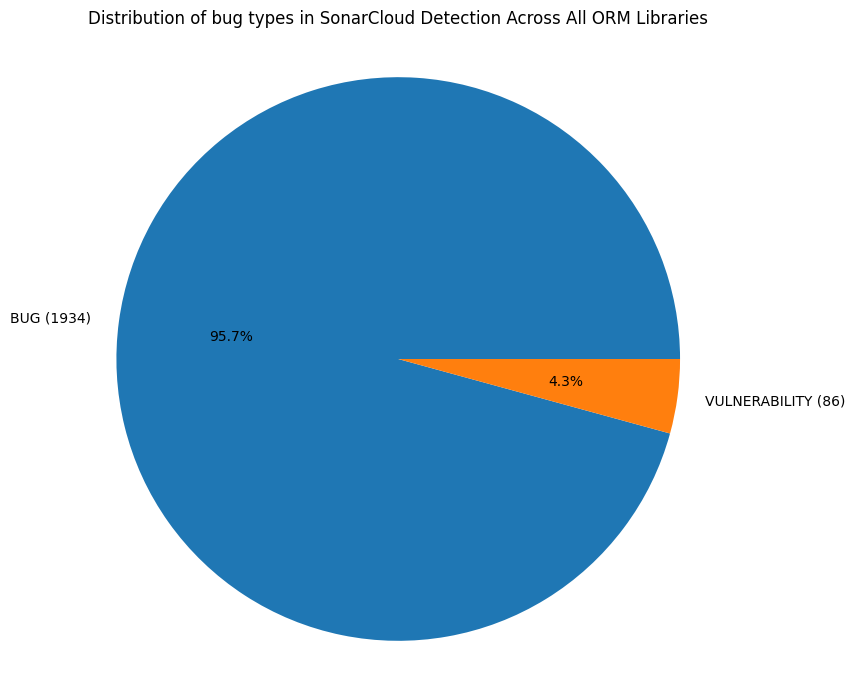

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

csv_paths = [
    "sonarcloud_data/sonarcloud_ebean.csv",
    "sonarcloud_data/sonarcloud_hibernate-orm.csv",
    "sonarcloud_data/sonarcloud_openjpa.csv",
    "sonarcloud_data/sonarcloud_ponyorm.csv",
    "sonarcloud_data/sonarcloud_sqlalchemy.csv"
]

ebean_df = pd.read_csv(csv_paths[0])
ebean_df['package'] = 'ebean'
hibernate_df = pd.read_csv(csv_paths[1])
hibernate_df['package'] = 'hibernate'
openjpa_df = pd.read_csv(csv_paths[2])
openjpa_df['package'] = 'openjpa'
ponyorm_df = pd.read_csv(csv_paths[3])
ponyorm_df['package'] = 'ponyorm'
sqlalchemy_df = pd.read_csv(csv_paths[4])
sqlalchemy_df['package'] = 'sqlalchemy'

sonarcloud_df = pd.concat([ebean_df, hibernate_df, openjpa_df, openjpa_df, ponyorm_df, sqlalchemy_df], ignore_index=True)
sonarcloud_df = sonarcloud_df[['package','file_path','line_number','type','severity','description']]

sonarcloud_type_proportion = sonarcloud_df['type'].value_counts()

plt.figure(figsize=(8,8))
plt.pie(sonarcloud_type_proportion, labels=[f"{index} ({sonarcloud_type_proportion[index]})" for index in sonarcloud_type_proportion.index],autopct='%1.1f%%')
plt.title('Distribution of bug types in SonarCloud Detection Across All ORM Libraries', pad=20)
plt.axis('equal')
plt.show()

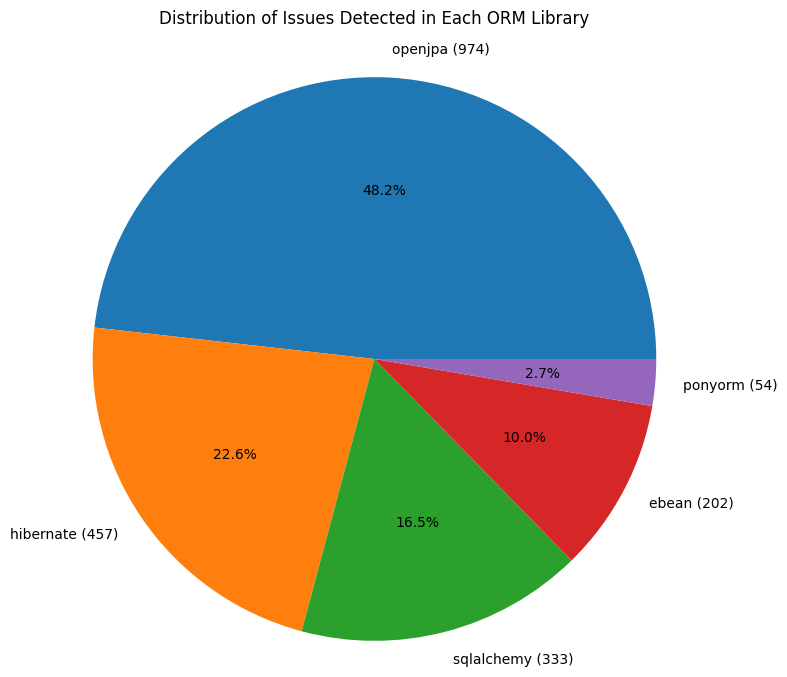

In [30]:
sonarcloud_package_proportion = sonarcloud_df['package'].value_counts()

plt.figure(figsize=(8,8))
plt.pie(sonarcloud_package_proportion, labels=[f"{index} ({sonarcloud_package_proportion[index]})" for index in sonarcloud_package_proportion.index],autopct='%1.1f%%')
plt.title('Distribution of Issues Detected in Each ORM Library', pad=20)
plt.axis('equal')
plt.show()

In [33]:
sonarcloud_sample = sonarcloud_df.sample(n=24, random_state=42)
sonarcloud_sample.to_csv('sonarcloud_data/sonarcloud_sample.csv', index=False)